<a href="https://colab.research.google.com/github/pedersor/ksr_dft/blob/main/examples/recover_potential_from_density_and_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Environment Setup

Change to GPU runtime: Runtime -> Change runtime type -> Hardware accelerator -> GPU

In [ ]:
# Check cuda version
! nvcc --version

The jaxlib version must correspond to the version of the existing CUDA installation you want to use, with e.g. `cuda111` for CUDA 11.1.

In [ ]:
# For GPU runtime
! pip install --upgrade pip
! pip install --upgrade jaxlib==0.1.72+cuda111 jax==0.2.19 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
# Install ksr-dft
! git clone https://github.com/pedersor/ksr_dft.git
! pip install ksr_dft

# Import and setup

In [1]:
import jax
from jax.config import config
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from ksr_dft import scf
from ksr_dft import utils


# Set the default dtype as float64
config.update('jax_enable_x64', True)

In [2]:
# Set plot style
import matplotlib as mpl

COLORS = [
    '#0072b2',
    '#de8f05',
    '#009e73',
    '#cc79a7',
    '#a24f00',
    '#9467bd',
    '#56b4e9',
    '#bcbd22',
    '#7f7f7f',
]


def set_matplotlib_style():
  """Sets the matplotlib style for the colab notebook."""
  mpl.rcParams['image.cmap'] = 'inferno'
  # Set width and size for lines and markers.
  mpl.rcParams['lines.linewidth'] = 2.5
  mpl.rcParams['lines.markersize'] = 9
  mpl.rcParams['lines.markeredgewidth'] = 0
  # Set fontsize.
  mpl.rcParams['font.size'] = 18
  mpl.rcParams['axes.labelsize'] = 20
  mpl.rcParams['axes.titlesize'] = 20
  mpl.rcParams['axes.formatter.useoffset'] = False
  mpl.rcParams['legend.fontsize'] = 14
  mpl.rcParams['xtick.labelsize'] = 14
  mpl.rcParams['ytick.labelsize'] = 14
  # default plot colors recommended by @zan
  # adapted from the seaborn colorblind colors.
  # https://seaborn.pydata.org/tutorial/color_palettes.html
  # Purposely avoids red both for colorblind reasons
  # and because red often reads as more important/bad or more eye-catching than
  # other colors.
  # These colors have been vetted by an individual with red/green color
  # confusion.
  mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLORS)
  mpl.rcParams['savefig.dpi'] = 120
  mpl.rcParams['savefig.bbox'] = 'tight'

set_matplotlib_style()

In [3]:
def show_density_potential(
    grids, density, potential, do_show=True, grey=False, axs=None):
  if axs is None:
    _, axs = plt.subplots(nrows=2)
  axs[0].plot(grids, density, c='0.5' if grey else COLORS[0])
  axs[1].plot(grids, potential, c='0.5' if grey else COLORS[1])
  axs[0].set_ylabel(r'$n(x)$')
  axs[1].set_ylabel(r'$v(x)$')
  axs[1].set_xlabel(r'$x$')
  if do_show:
    plt.show()

# Run

## Define grids

In [4]:
grids = np.linspace(-5, 5, 201)
dx = utils.get_dx(grids)

## Quantum Harmonic Oscillator

$v(x)=\frac{1}{2}k x^2$, where $k=1$.

The ground state energy is $0.5$ Hartree.



total energy: 0.49999993499530004


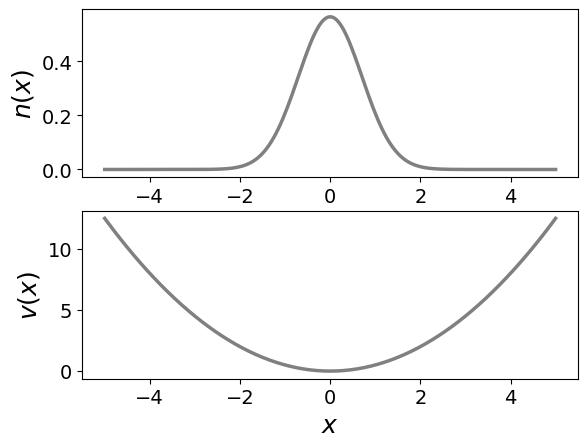

In [5]:
qho_potential = 0.5 * grids ** 2

qho_density, qho_energy, _ = (
    scf.solve_noninteracting_system(
        qho_potential,
        num_electrons=1,
        grids=grids))

print(f'total energy: {qho_energy}')
show_density_potential(grids, qho_density, qho_potential, grey=True)

## Perturbed Quantum Harmonic Oscillator

Let's add a perturbation on the potential. We will see that the density is of course not the original density.

total energy: 0.6339977312406904


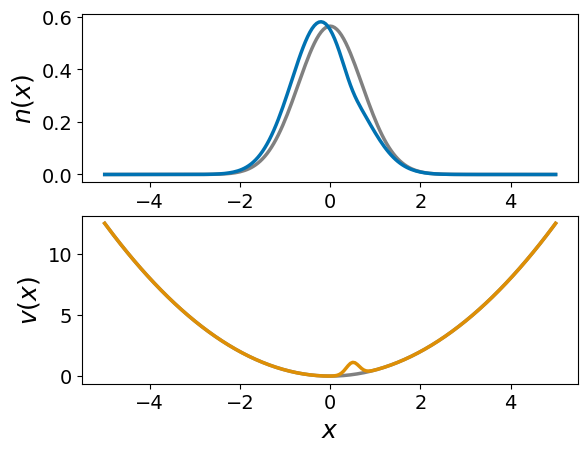

In [6]:
perturbed_potential = qho_potential + np.exp(-(grids - 0.5) ** 2 / 0.04)
perturbed_density, perturbed_energy, _ = (
    scf.solve_noninteracting_system(
        perturbed_potential,
        num_electrons=1,
        grids=grids))

print(f'total energy: {perturbed_energy}')
_, axs = plt.subplots(nrows=2)
show_density_potential(
    grids, qho_density, qho_potential, grey=True, do_show=False, axs=axs)
show_density_potential(
    grids, perturbed_density, perturbed_potential, axs=axs)

## Adjust potential from loss

$L=\int (n - n_\mathrm{QHO})^2 dx + (E - E_\mathrm{QHO})^2$

In [7]:
# Note the use of `jnp` not `np` here.
def density_loss(output, target):
  return jnp.sum((output - target) ** 2) * dx

def energy_loss(output, target):
  return (output - target) ** 2

In [8]:
print(f'Current density loss {density_loss(perturbed_density, qho_density)}')
print(f'Current energy loss {energy_loss(perturbed_energy, qho_energy)}')
print(f'Current total loss {density_loss(perturbed_density, qho_density) + energy_loss(perturbed_energy, qho_energy)}')

Current density loss 0.014992231403574353
Current energy loss 0.01795540939862114
Current total loss 0.03294764080219549


In [9]:
def loss_fn(potential):
  density, energy, _ = scf.solve_noninteracting_system(
      potential, num_electrons=1, grids=grids)
  return density_loss(density, qho_density) + energy_loss(energy, qho_energy)

In [10]:
print(f'Loss with perturbed potential {loss_fn(perturbed_potential)}')
print(f'Loss with QHO potential {loss_fn(qho_potential)}')

Loss with perturbed potential 0.03294764080219549
Loss with QHO potential 0.0


You can get the gradient $\frac{\partial L_n}{\partial v}$ via automatic differentiation from `jax.grad`

In [11]:
grad_fn = jax.jit(jax.grad(loss_fn))  # Compile with jit for fast grad.

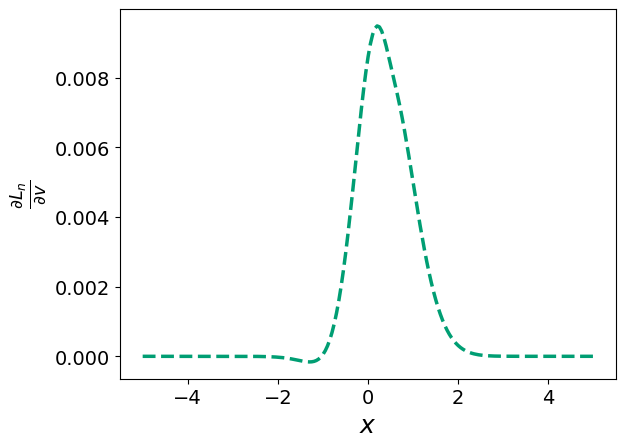

In [12]:
plt.plot(grids, grad_fn(perturbed_potential), '--', c=COLORS[2])
plt.xlabel(r'$x$')
plt.ylabel(r'$\frac{\partial L_n}{\partial v}$')
plt.show()

Now we have the gradient. Let's update the potential from the graident of loss with respect to the potential.

$$v\leftarrow v - \epsilon\frac{\partial L}{\partial v}$$

In [13]:
potential = perturbed_potential
loss_history = []
potential_history = []
record_interval = 1000
for i in range(5001):
  if i % record_interval == 0:
    loss_value = loss_fn(potential)
    print(f'step {i}, loss {loss_value}')
    loss_history.append(loss_value)
    potential_history.append(potential)
  potential -=  30 * grad_fn(potential)

step 0, loss 0.03294764080219549
step 1000, loss 1.2281985713177845e-06
step 2000, loss 2.6990566010310794e-07
step 3000, loss 1.0985142405744328e-07
step 4000, loss 5.551165719139105e-08
step 5000, loss 3.074022313806995e-08


Visualize the learning curve

In [14]:
history_size = len(loss_history)

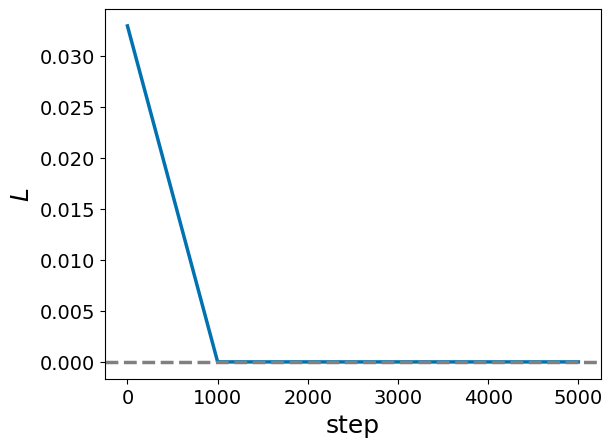

In [15]:
plt.plot(np.arange(history_size) * record_interval, loss_history)
plt.axhline(y=0, color='0.5', ls='--')
plt.xlabel('step')
plt.ylabel(r'$L$')
plt.show()

and how the potential and corresponding density change.

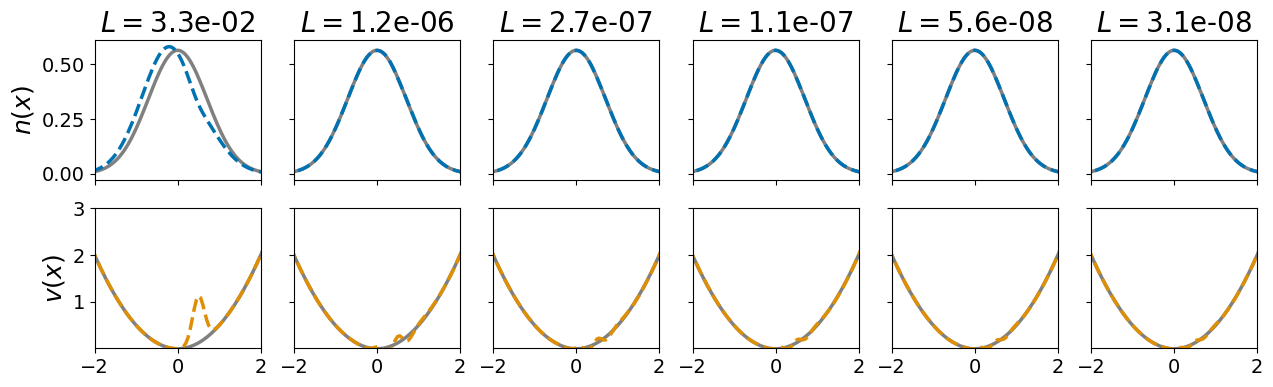

In [16]:
_, axs = plt.subplots(
    nrows=2, ncols=history_size, figsize=(2.5 * history_size, 4),
    sharex=True, sharey='row')
for i, ax in enumerate(axs[0]):
  ax.plot(grids, qho_density, c='0.5')
  density, _, _ = scf.solve_noninteracting_system(
      potential_history[i], num_electrons=1, grids=grids)
  ax.plot(grids, density, '--', c=COLORS[0])
  ax.set_title(rf'$L=${loss_fn(potential_history[i]):1.1e}')

for i, ax in enumerate(axs[1]):
  ax.plot(grids, qho_potential, c='0.5')
  ax.plot(grids, potential_history[i], '--', c=COLORS[1])

# Zoom in the potential.
axs[1][0].set_xlim(-2, 2)
axs[1][0].set_ylim(0.01, 3)
axs[0][0].set_ylabel(r'$n(x)$')
axs[1][0].set_ylabel(r'$v(x)$')
plt.show()

Visualize the final result.

total energy: 0.4999996749449337


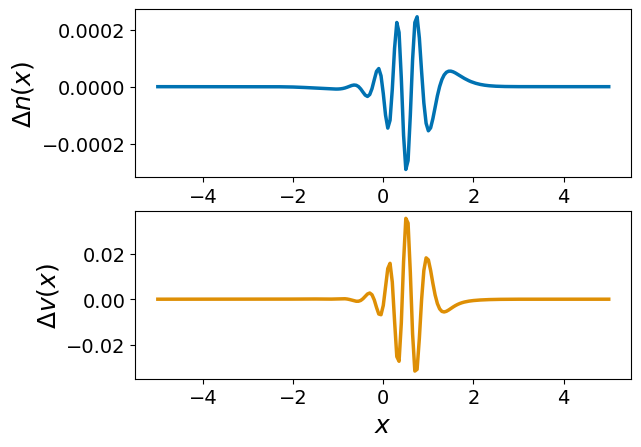

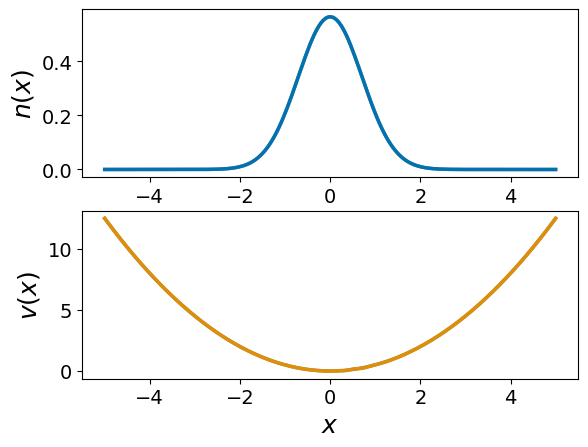

In [17]:
optimized_potential = potential_history[-1]
optimized_density, optimized_total_eigen_energies, _ = (
    scf.solve_noninteracting_system(
        optimized_potential,
        num_electrons=1,
        grids=grids))

print(f'total energy: {optimized_total_eigen_energies}')

_, axs = plt.subplots(nrows=2)
axs[0].plot(grids, optimized_density - qho_density, c=COLORS[0])
axs[0].set_ylabel(r'$\Delta n(x)$')
axs[1].plot(grids, optimized_potential - qho_potential, c=COLORS[1])
axs[1].set_ylabel(r'$\Delta v(x)$')
axs[1].set_xlabel(r'$x$')
plt.show()

_, axs = plt.subplots(nrows=2)
show_density_potential(
    grids, qho_density, qho_potential, grey=True, do_show=False, axs=axs)
show_density_potential(
    grids, optimized_density, optimized_potential, axs=axs)